In [2]:

import pandas as pd 
import numpy as np 
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

#import and store dataset

credit_card_data= pd.read_csv('creditcard.csv')
credit_card_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
credit_card_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Data
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

# Exploratory Data Analysis

In [4]:

credit_card_data.isnull().values.any()

False

In [31]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = credit_card_data[credit_card_data['Class']==1]
Valid = credit_card_data[credit_card_data['Class']==0]
outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)
print("Fraud Cases : {}".format(len(Fraud)))
print("Valid Cases : {}".format(len(Valid)))

0.0017304750013189597
Fraud Cases : 492
Valid Cases : 284315


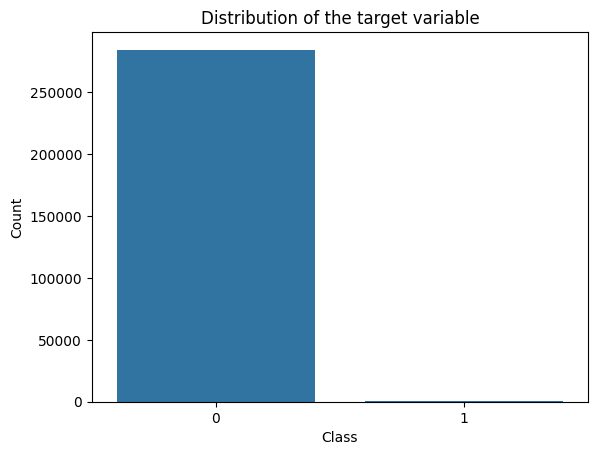

In [5]:
#Plotting the count of each class in the target variable
sns.countplot(x='Class', data=credit_card_data)

#Adding the title, x-axis label and y-axis label to the plot
plt.title("Distribution of the target variable")
plt.xlabel("Class")
plt.ylabel("Count")

#Displaying the plot
plt.show()

In [6]:
print(credit_card_data['Amount'].describe())

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64


The mean transtacted amout for all cases (normal and fraud) is around 88 dollars with a standard deviation of 250 dollars. The maximum transtacted abount in two days was 25691.16 dollars and the minimum transtactes about was 0 dollars. 

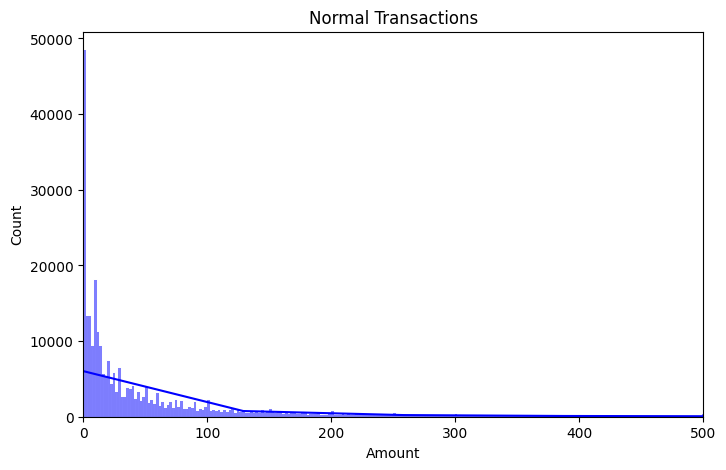

In [7]:
# Create a subplot with two plots side by side
fig, axs = plt.subplots(1, 1, figsize=(8, 5))

# Plot distribution of amount for class 0
sns.histplot(credit_card_data[credit_card_data['Class'] == 0]['Amount'], kde=True, ax=axs, color='b')
axs.set_title('Normal Transactions')
axs.set_xlabel('Amount')
axs.set_ylabel('Count')
axs.set_xlim(0, 500) 

plt.show()

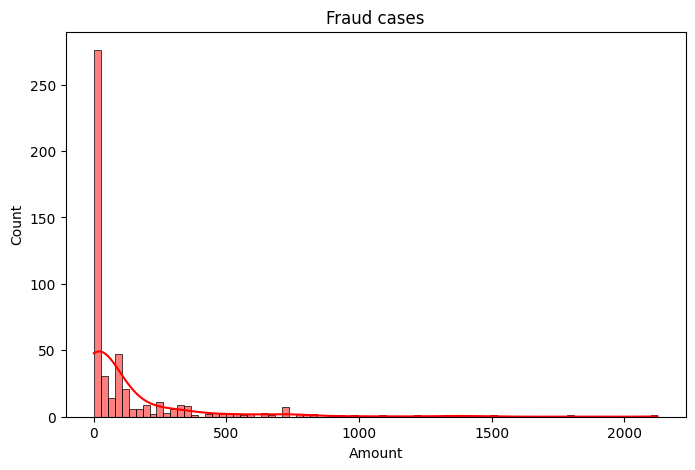

In [8]:
# Create a subplot with two plots side by side
fig, axs = plt.subplots(1,1, figsize=(8, 5))


# Plot distribution of amount for class 1
sns.histplot(credit_card_data[credit_card_data['Class'] == 1]['Amount'], kde=True, ax=axs, color='r')
axs.set_title('Fraud cases')
axs.set_xlabel('Amount')
axs.set_ylabel('Count')

plt.show()

In [9]:
## Get the Fraud and the normal dataset 
fraud = credit_card_data[credit_card_data['Class']==1]
normal = credit_card_data[credit_card_data['Class']==0]

In [10]:
print(normal['Amount'].describe())

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64


In [11]:
print(fraud['Amount'].describe())

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


The mean transtacted amout for cases normal is around 88 dollars with a standard deviation of 250 dollars. The maximum transtacted abount in two days was 25691.16 dollars and the minimum transtactes about was 0 dollars. For fraud cases the mean is hight at around 122 dollars with a standard deviation of 256 dollars. The largest fraud case was 2125 usd dollars. The histogram show the data is highly skewed to the right with most transaction recorded at 0 dollars in both normal transaction and fraud transaction. 

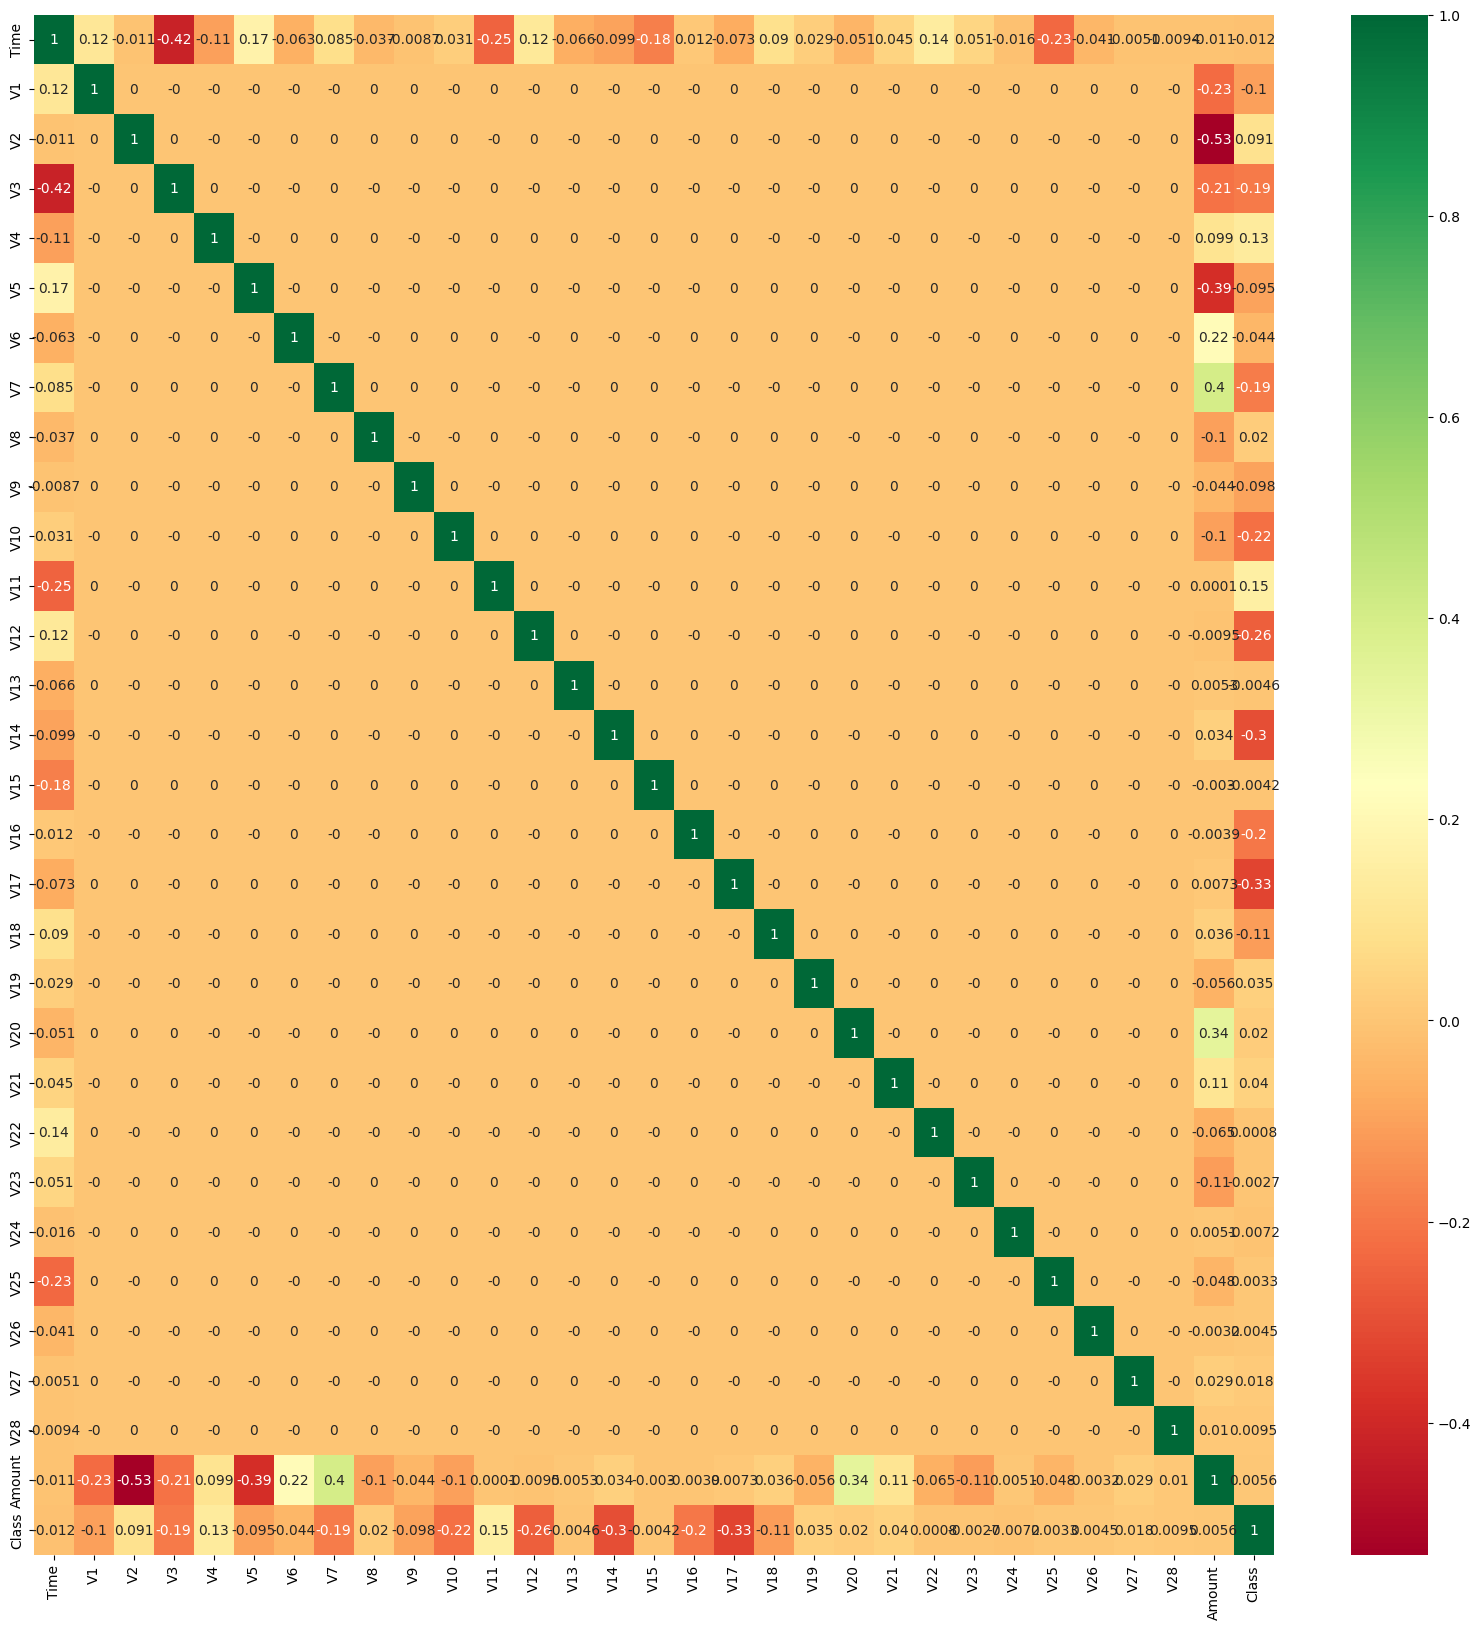

In [12]:
## Correlation
#get correlations of each features in dataset
corrmat = round(credit_card_data.corr(),4)
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(corrmat,annot=True,cmap="RdYlGn")



### Steps for the Analysis
1. **Shuffle the Data**  
   Randomly shuffle the dataset to remove any potential order bias and ensure a fair distribution of classes during splitting.

2. **One-Hot Encoding**  
   Transform categorical variables (e.g., the `Class` column) into binary columns to make the data suitable for machine learning algorithms.

3. **Normalize the Data**  
   Scale the feature values to fall within the range [0, 1], ensuring that all features contribute equally to the model.

4. **Split Features and Labels (X and y)**  
   Separate the dataset into independent variables (X) and target variables (y) for model training.

5. **Convert to NumPy Arrays**  
   Convert the dataframes to NumPy arrays for efficient numerical computation and compatibility with machine learning libraries.

6. **Split Data into Training and Testing Sets**  
   Divide the data into training and testing subsets to evaluate the model's performance on unseen data.



In [13]:
#shuffle and randomize data 
shuffled_data= credit_card_data.sample(frac=1)

In [14]:
#one-hot encoding by changing class column into class_0(1,0) for legit and class_1(0,1) for fraudulent data
one_hote_data= pd.get_dummies(shuffled_data, columns=['Class'])
one_hote_data = one_hote_data.astype(float)
normalized_data= (one_hote_data-one_hote_data.min())/(one_hote_data.max()-one_hote_data.min())

#store clumns v1 to v28 for df_X and column Class_0 and Class_1 for df_ y
df_X= normalized_data.drop(['Class_0', 'Class_1'], axis=1)
df_y= normalized_data[["Class_0", "Class_1"]]

In [15]:
#convert both dataset into np arrays of float32
ar_X, ar_y= np.asarray(df_X.values, dtype="float32"), np.asarray(df_y.values, dtype="float32")


### Important Note
The dataset is highly imbalanced, with significantly fewer instances of fraudulent transactions compared to legitimate ones. To address this imbalance, we can apply **logit weighting**. This technique adjusts the importance of the minority class, ensuring the model pays more attention to underrepresented data during training.


In [16]:
#split data into 80% traininga an 20% test
train_size= int(0.8*len(ar_X))
(raw_X_train, raw_y_tarin)= (ar_X[:train_size], ar_y[:train_size])
(raw_X_test, raw_y_test)= (ar_X[train_size:], ar_y[train_size:])

In [17]:
#let first see the ratio . Note that 0.0017% of the transactions are fraudulent
count_legit, count_fraud=  np.unique(credit_card_data['Class'],return_counts=True)[1]
fraud_ratio= count_fraud/(count_legit+count_fraud)
print('%/ fraud ratio', fraud_ratio)


%/ fraud ratio 0.001727485630620034


In [18]:
weighting= 1/fraud_ratio #this will be multiplied by our y data
raw_y_tarin[:,1]= raw_y_tarin[:,1]*weighting

In [19]:
raw_y_tarin[:,1]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [20]:

#Building the computation model
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [21]:
# 30 cells for the input
input_dimensions= ar_X.shape[1]
print(input_dimensions)
#2 cells for the output
output_dimensions= ar_y.shape[1]
print(output_dimensions)
# 100 cells for the first layer
num_layer_1_cells= 100
# 150 cells for the second layer
num_layer_2_cells= 150

30
2


In [22]:
#This will be used as input to the model when it comes time to train it, we will assing values at run time
X_train_node= tf.placeholder(tf.float32, [None, input_dimensions], name="X_train" )
y_train_node= tf.placeholder(tf.float32, [None, output_dimensions], name="y_train")

#This will be used as inputs to the model once it is time to test the model
X_test_node= tf.constant(raw_X_test, name="X_test")
y_test_node= tf.constant(raw_y_test, name="y_test")

#the first layer takes in input and passes output to 2nd layer
weight_1_node= tf.Variable(tf.zeros([input_dimensions,num_layer_1_cells]), name="weight_1")
biases_1_node= tf.Variable(tf.zeros([num_layer_1_cells]), name="biases_1")

#the second layer takes in input from the first layer and passes output to 3rd layer
weight_2_node= tf.Variable(tf.zeros([num_layer_1_cells,num_layer_2_cells]), name="weight_2")
biases_2_node= tf.Variable(tf.zeros([num_layer_2_cells]), name="biases_2")

#the third layer takes in input from 2nd layer and output [1,0] or [0,1] depending on the case, whether fraud or legit
weight_3_node= tf.Variable(tf.zeros([num_layer_2_cells,output_dimensions]), name="weight_3")
biases_3_node= tf.Variable(tf.zeros([output_dimensions]), name="biases_3")




### Create a Neural Network Function
Develop a function that processes an input tensor through three distinct layers and outputs a tensor indicating whether a transaction is fraudulent or legitimate. Each layer employs a unique activation function to model the relationships within the data and make accurate predictions based on the input tensor.

In [23]:
def network (input_tensor):
    layer1= tf.nn.sigmoid(tf.matmul(input_tensor,weight_1_node)+biases_1_node)
    #use drop out function to prevent the model from being lazy
    layer2= tf.nn.dropout(tf.nn.sigmoid(tf.matmul(layer1,weight_2_node)+biases_2_node),0.85)
    #use sofmax function because it works well with one-hot coding
    layer3= tf.nn.softmax(tf.matmul(layer2,weight_3_node)+biases_3_node)
    return layer3


### Create a Prediction Function
This function is designed to predict outcomes based on the input training or testing data. It's important to note that `x_train_node` serves as a placeholder, with actual values being provided dynamically at runtime.


In [24]:
y_train_prediction= network(X_train_node)
print(y_train_prediction)
y_test_prediction= network(X_test_node)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Tensor("Softmax:0", shape=(?, 2), dtype=float32)


In [25]:
# Cross entropy loss function measures difference between actual output and predicted output
cross_entropy= tf.losses.softmax_cross_entropy(y_train_node, y_train_prediction)

#The adam optimizer function will try to minimize loss(cross_entropty) but changing 3 layers' variable
#values at a learning rate of 0.005
optimizer= tf.train.AdamOptimizer(0.005).minimize(cross_entropy)

In [26]:
#create a function to calulate the accuracy
def calculate_accuracy(actual,predicted):
    actual= np.argmax(actual,1)
    predicted= np.argmax(predicted,1)
    return (100*np.sum(np.equal(predicted,actual))/predicted.shape[0])



In [27]:
num_epochs= 100

import time 

In [28]:
with tf.Session() as session:
    tf.global_variables_initializer().run()
    for epoch in range(num_epochs):
        start_time= time.time()
        _,cross_entropy_score= session.run([optimizer,cross_entropy], 
                                           feed_dict= {X_train_node:raw_X_train,
                                                       y_train_node:raw_y_tarin})
        if epoch %10 ==0:
            timer= time.time()- start_time

            print('Epoch: {}'.format(epoch), 'Cureent loss: {0:.5f}'.format(cross_entropy_score),
                   'Elapsed time: {0:.2f}'.format(timer))
            
            final_y_test= y_test_node.eval()
            final_y_test_prediction= y_test_prediction.eval()
            final_accuracy= calculate_accuracy(final_y_test, final_y_test_prediction)
            print('current accuracy {0:.2f}%'.format(final_accuracy))

    final_y_test= y_test_node.eval()
    final_y_test_prediction= y_test_prediction.eval()
    final_accuracy= calculate_accuracy(final_y_test, final_y_test_prediction)
    print('final accuracy {0:.2f}%'.format(final_accuracy))
            

Epoch: 0 Cureent loss: 1.38053 Elapsed time: 0.74
current accuracy 99.78%
Epoch: 10 Cureent loss: 1.37923 Elapsed time: 0.66
current accuracy 30.46%
Epoch: 20 Cureent loss: 1.34361 Elapsed time: 0.66
current accuracy 68.74%
Epoch: 30 Cureent loss: 1.19565 Elapsed time: 0.66
current accuracy 93.64%
Epoch: 40 Cureent loss: 1.01464 Elapsed time: 0.69
current accuracy 96.18%
Epoch: 50 Cureent loss: 0.91097 Elapsed time: 0.70
current accuracy 98.93%
Epoch: 60 Cureent loss: 0.85445 Elapsed time: 0.79
current accuracy 99.52%
Epoch: 70 Cureent loss: 0.83551 Elapsed time: 0.65
current accuracy 99.70%
Epoch: 80 Cureent loss: 0.81657 Elapsed time: 0.69
current accuracy 99.53%
Epoch: 90 Cureent loss: 0.80908 Elapsed time: 0.69
current accuracy 99.76%
final accuracy 99.41%


In [6]:
final_fraud_y_test= final_y_test[final_y_test[:,1]==1]
final_fraud_y_test_prediction= final_y_test_prediction[final_y_test[:,1]==1]
final_fraud_accuracy= calculate_accuracy(final_fraud_y_test,final_fraud_y_test_prediction)
print('Final fraud specific accuracy: {0:.2f}%'.format(final_fraud_accuracy))

NameError: name 'final_y_test' is not defined

pip install tensorflow==2.10.1
pip install numpy==1.24

# Model Prediction with Isolation Forest Algorithm and Local Outlier Factor(LOF) Algorithm
## Isolation Forest Algorithm:

The Isolation Forest (iForest) algorithm is a machine learning technique used primarily for anomaly detection. It works on the principle of isolating anomalies rather than profiling normal data points, making it highly efficient for detecting outliers in high-dimensional datasets.
The Isolation Forest (iForest) algorithm is a machine learning technique used primarily for **anomaly detection**. It works on the principle of isolating anomalies rather than profiling normal data points, making it highly efficient for detecting outliers in high-dimensional datasets. Here's a breakdown of the algorithm:

---

### **Key Concepts**
1. **Isolation**:
   - Anomalies are data points that are few and different from the majority of the dataset.
   - Since anomalies are rare, they are easier to isolate compared to normal observations.

2. **Random Splits**:
   - The algorithm partitions the data space using random splits on randomly selected features.
   - The fewer splits required to isolate a point, the more likely it is an anomaly.

3. **Tree Structure**:
   - The data is recursively split to build a tree structure, called an **Isolation Tree (iTree)**.
   - Each node in the tree represents a split based on a randomly chosen feature and threshold.

4. **Path Length**:
   - The path length of a data point in the tree is the number of splits required to isolate it.
   - Anomalies tend to have shorter paths since they are isolated quickly.

---

### **How It Works**
1. **Subsampling**:
   - A small, random subset of the data is sampled for building each tree to ensure efficiency and randomness.

2. **Tree Building**:
   - Each tree is constructed by randomly selecting a feature and splitting value.
   - Splitting continues until:
     - The data points are fully isolated (i.e., only one point per leaf), or
     - A predefined maximum tree height is reached.


3. **Scoring**:
   - The algorithm computes an **anomaly score** for each data point based on the average path length across all trees.
   - The anomaly score \( s(x, n) \) for a data point \( x \) is calculated as:
     \[
     s(x, n) = 2^{-\frac{E(h(x))}{c(n)}}
     \]
     where:
     - \( E(h(x)) \): Expected path length for \( x \).
     - \( c(n) \): Normalizing factor for the average path length in a binary tree.
   - Scores close to 1 indicate anomalies, while scores near 0 indicate normal points.

---

### **Advantages**
1. **Efficiency**:
   - Linear time complexity, \( O(n \log n) \), with \( n \) being the number of data points.
   - Scales well to large datasets.

2. **No Assumptions**:
   - Does not assume any prior distribution for the data.

3. **Multidimensional Data**:
   - Handles high-dimensional data effectively.

4. **Unsupervised**:
   - Does not require labeled data for training.

---

### **Limitations**
1. **Data Size Sensitivity**:
   - Performance can degrade if the sample size is too small or too large.

2. **Parameter Tuning**:
   - Choosing parameters such as the number of trees, subsample size, and maximum tree height can affect results.

3. **High Overlap**:
   - May struggle in datasets where anomalies closely resemble normal data.


### **Applications**
1. Fraud Detection (e.g., credit card transactions).
2. Network Intrusion Detection.
3. Manufacturing Defect Detection.
4. Healthcare (e.g., detecting rare diseases).
5. Finance (e.g., identifying rogue trades).


## Local Outlier Factor (LOF) Algorithm

The **Local Outlier Factor (LOF)** algorithm is a density-based anomaly detection method that identifies data points with significantly lower densities than their neighbors. It measures the local deviation of density for a given data point compared to its neighborhood.

### Key Concepts

1. **Local Density**:
   LOF measures the density of a data point relative to its local neighborhood.

2. **Anomalies**:
   A data point is considered an anomaly if its density is significantly lower than the densities of its neighbors.

3. **Reachability Distance**:
   The reachability distance between two points \( p \) and \( o \) is defined as:
   $$
   \text{reach-dist}(p, o) = \max(\text{k-distance}(o), \text{distance}(p, o))
   $$
   where:
   - \( \text{k-distance}(o) \): The distance of \( o \) to its \( k \)-th nearest neighbor.
   - \( \text{distance}(p, o) \): The actual distance between \( p \) and \( o \).

4. **Local Reachability Density (LRD)**:
   The local reachability density of a point \( p \) is the inverse of the average reachability distance of \( p \) to its \( k \)-nearest neighbors:
   $$
   \text{LRD}(p) = \left( \frac{\sum_{o \in N_k(p)} \text{reach-dist}(p, o)}{|N_k(p)|} \right)^{-1}
   $$

5. **Local Outlier Factor**:
   The LOF score for a point \( p \) is calculated as:
   $$
   \text{LOF}(p) = \frac{\sum_{o \in N_k(p)} \text{LRD}(o)}{|N_k(p)| \cdot \text{LRD}(p)}
   $$
   A higher LOF score indicates that the point is more likely to be an anomaly.

### Advantages
- **Density-Based**: Effective for detecting anomalies in clusters of varying density.
- **Unsupervised**: Does not require labeled data for training.
- **Flexible**: Works well for multivariate and high-dimensional data.

### Limitations
- **Computational Complexity**: LOF can be computationally expensive for large datasets due to the \( k \)-nearest neighbor calculation.
- **Parameter Sensitivity**: Performance depends on the choice of \( k \) (number of neighbors).
- **Global Anomalies**: LOF focuses on local anomalies and may not detect global outliers effectively.

### Applications
- Fraud detection (e.g., unusual transactions).
- Intrusion detection in networks.
- Medical diagnostics (e.g., identifying rare conditions).
- Image processing (e.g., detecting abnormal objects in images).



In [3]:
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams

In [32]:
#Create independent and Dependent Features
columns = credit_card_data.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X = credit_card_data[columns]
Y = credit_card_data[target]
#X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


In [36]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))


Isolation Forest: 675
Accuracy Score :
0.9976299739823811
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.31      0.32      0.31       492

    accuracy                           1.00    284807
   macro avg       0.66      0.66      0.66    284807
weighted avg       1.00      1.00      1.00    284807

Local Outlier Factor: 935
Accuracy Score :
0.9967170750718908
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.05      0.05      0.05       492

    accuracy                           1.00    284807
   macro avg       0.52      0.52      0.52    284807
weighted avg       1.00      1.00      1.00    284807

